## [2주차_기다연] 신경망, 자연어와 단어의 분산 표현
1. BeautifulSoup을 통해 아마존 '기생충' 영화 리뷰 데이터 크롤링
2. 데이터셋 EDA, 전처리, Tokenization
3. 단어 빈도 행렬 생성 (동시발생행렬, n-gram 기반)
4. 동시발생 행렬 기반 PPMI Matrix 생성
5. Truncated SVD (특이값 분해)를 이용한 차원 감소
6. 코사인 유사도 기반 유사 랭킹 생성
7. 자주 등장하는 단어 워드 클라우드 생성

In [ ]:
#Initial Setting (font, display)
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic') 

import matplotlib
get_ipython().run_line_magic('config', "InlineBackend.figure_format='retina'") #화질 보정

### 1) BeautifulSoup을 통해 원하는 데이터 크롤링
출처: [Amazon Review(기생충 영화)](https://www.amazon.com/product-reviews/B07YM14FRG/ref=atv_dp_cr_see_all?ie=UTF8&reviewerType=all_reviews)<br>
'기생충' 영화를 보다가 해외에서의 반응은 어떨지 궁금해져 본 영화에 대한 Amazon 리뷰 데이터를 크롤링해왔습니다.

In [ ]:
import os
import re
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import svds #SVD
from string import punctuation

#NLP Preprocessing package
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import string
print('Ready')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Ready


In [ ]:
!pip3 install selenium

     |████████████████████████████████| 904 kB 9.2 MB/s 


In [ ]:
#Packages for data crawling
from selenium import webdriver
from urllib.request import urlopen
from bs4 import BeautifulSoup as bs
from selenium.webdriver.common.keys import Keys
import time
import sys
import requests

#colab에서 selenium을 사용하기 위해서는 지정해줘야 하는 부분
!apt-get update
!apt install chromium-chromedriver

In [ ]:
options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument("--single-process")
options.add_argument("--disable-dev-shm-usage")
driver = webdriver.Chrome('chromedriver', options=options)

delay_time = 0.5
driver.implicitly_wait(delay_time)

In [ ]:
#Data Crawling (기생충 영화 리뷰 데이터)
#영화 리뷰 데이터 데이터프레임 생성
movie_review = pd.DataFrame(columns = ['review'])

#리뷰 5000개만 가져오기 (1페이지당 10개의 리뷰가 있으므로 pageNumber=500까지)
for k in range(1, 501):
  url = "https://www.amazon.com/product-reviews/B07YM14FRG/ref=atv_dp_cr_see_all?ie=UTF8&reviewerType=all_reviews&pageNumber=%d" % k
  driver.get(url)

  for i in range(1, 11):
    info = driver.find_elements_by_xpath("/html/body/div[1]/div[3]/div/div[1]/div/div[1]/div[5]/div[3]/div/div[%d]/div/div" % i)

    review_list = []
    for n in info:
      review = n.find_element_by_xpath("/html/body/div[1]/div[3]/div/div[1]/div/div[1]/div[5]/div[3]/div/div[%d]/div/div/div[4]/span/span" % i)
      review = review.text
      review_list.append(review)
    
      new_data = {'review': review}
      movie_review = movie_review.append(new_data, ignore_index=True)

In [ ]:
movie_review[:10]

,review
0,It's incredibly dense with philosophical and c...
1,"""Parasite"" (2019 release from South Korea; 132..."
2,IMO: I get some of the issues of class struggl...
3,"Honestly when I first saw the movie, I had no ..."
4,the most over-rated film of 2019.
5,Wow. A truly exceptional film that somehow liv...
6,I watched the trailer and laughed along as I r...
7,I don't believe the accolades this film is get...
8,Theater review. Possible spoilers. One of my f...
9,What a stupid movie!! I can't believe I actual...


### 2) 데이터셋 EDA, 전처리, Tokenization

In [ ]:
!pip3 install konlpy

In [ ]:
#NLP packages
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
#check NULL value
print(movie_review.isnull().values.any())

False


**전처리 과정**<br>
1. 모두 소문자로 변환
2. accent된 문자 제외한 뒤 인코딩
3. 특수문자, 부호 제외한뒤 단어리스트 생성
4. 불용어 제거 (nltk stopwords 리스트 활용)

In [ ]:
stopwords_set = set(stopwords.words('english')) #nltk english stopwords
stop_words = "movie film watch" #영화 관련 불용어 직접 정의
stop_words = stop_words.split(' ')

def preprocess(x):
  sent = x.lower() #소문자 변환
  sent = sent.encode('ascii', 'ignore').decode() #accent 된 문자가 들어가는 경우 제외 (영어문자만 취급)
  sent = ''.join([c for c in sent if c not in string.punctuation]) #특수문자, 부호 제외하고, 문장별 단어리스트 생성
  sent = [word for word in sent.split() if word not in stopwords_set] #불용어 제거
  sent = [word for word in sent if word not in stop_words]
  return sent

preprocessed = movie_review['review'].apply(preprocess) #df.apply 행/열/전체원소에 대해 원하는 함수 지원
print(preprocessed[:10])

0    [incredibly, dense, philosophical, cultural, c...
1    [parasite, 2019, release, south, korea, 132, m...
2    [imo, get, issues, class, struggle, seems, con...
3    [honestly, first, saw, idea, hadnt, read, revi...
4                                    [overrated, 2019]
5    [wow, truly, exceptional, somehow, lives, imme...
6    [watched, trailer, laughed, along, read, subti...
7    [dont, believe, accolades, getting, genuine, s...
8    [theater, review, possible, spoilers, one, fav...
9    [stupid, cant, believe, actually, bought, perf...
Name: review, dtype: object


### 3) 단어 빈도 행렬 생성 (동시발생행렬, n-gram 기반)

In [ ]:
from collections import Counter
from itertools import combinations #리스트 원소들의 조합 count 후 튜플 리스트로 리턴

unigram = Counter() #한 단어의 빈도 수 
bigram = Counter() #두 단어 조합의 빈도수 

for sent in preprocessed:
  for word in sent: # unigram 
    unigram[word] += 1
  for w1, w2 in map(sorted, combinations(sent, 2)): #bigram count (같은 단어의 쌍도 포함)
    bigram[(w1, w2)] += 1

In [ ]:
min_count = (1/1000)*len(preprocessed) #전체 문장(10,000개) 중 0.0001 = 10번 이하로 등장하는 단어(저빈도 단어) 제거 (데이터셋 크기가 작기 때문에)
max_count = (1/20)*len(preprocessed) #전체문장의 반 이상 등장하는 단어(고빈도 단어) 제거

for word in list(unigram.keys()): #단어 리스트
  if unigram[word] < min_count or unigram[word] > max_count:
    del unigram[word]

print('After removal: ' + str(len(unigram))) 
print('Most common(unigram): ', unigram.most_common()[:10])

After removal: 2592
Most common(unigram):  [('interesting', 135), ('dark', 134), ('characters', 132), ('recommend', 130), ('funny', 129), ('social', 127), ('love', 125), ('something', 123), ('ive', 122), ('better', 119)]


In [ ]:
#Bigram에서도 저빈도/고빈도제거
for w1, w2 in list(bigram.keys()):
  if w1 not in unigram or w2 not in unigram: 
    del bigram[(w1, w2)]

print('After removal: ' + str(len(bigram))) 
print('Most common(bigram): ', bigram.most_common()[:10])

After removal: 501997
Most common(bigram):  [(('de', 'la'), 113), (('kim', 'park'), 97), (('park', 'parks'), 91), (('bong', 'park'), 90), (('kims', 'park'), 82), (('kims', 'parks'), 79), (('commentary', 'social'), 73), (('parks', 'two'), 66), (('parks', 'parks'), 66), (('de', 'que'), 65)]


### 4) 동시발생 행렬 기반 PPMI Matrix 생성
: PMI를 이용해서 통계 기반 방법이었던 n-gram 동시발생행렬의 한게점 보완 가능, 하지만 PMI matrix 자체도 2개 단어의 동시발생 횟수가 0이면 0으로 나타나기 때문에 PPMI matrix 사용

In [ ]:
#단어 리스트, id 리스트 각각 생성
word_to_id, id_to_word = {}, {}

for id, word in enumerate(unigram.keys()):
  word_to_id[word] = id
  id_to_word[id] = word

In [ ]:
uni_sum = sum(unigram.values()) #개별 단어 등장 횟수 sum
bi_sum = sum(bigram.values()) #조합 등장 횟수 sum

In [ ]:
from scipy.sparse import csc_matrix #compressed sparse matrix

ppmi_rates = Counter()
rates, rows, cols = [], [], []
eps = 1e-8

for (w1, w2), n in bigram.items(): #n은 bigram 발생 횟수
  rows.append(word_to_id[w1])
  cols.append(word_to_id[w2])
  rates.append(max(0,np.log2( (n/bi_sum) / (unigram[w1]/uni_sum) / (unigram[w2]/uni_sum) + eps))) #divided by 0 방지
  ppmi_rates[(w1,w2)] = rates[-1]

#PPMI 행렬 생성
PPMI = csc_matrix((rates, (rows, cols)))
ppmi_rates.most_common()[:10] #관련 있는 단어 상위 10개 출력

[(('deprivation', 'indifference'), 10.247926172645066),
 (('disque', 'lecteur'), 10.247926172645066),
 (('boitier', 'lecteur'), 10.247926172645066),
 (('br', 'lecteur'), 10.247926172645066),
 (('boitier', 'disque'), 10.247926172645066),
 (('br', 'disque'), 10.247926172645066),
 (('boitier', 'br'), 10.247926172645066),
 (('ie', 'myths'), 9.832888673370178),
 (('bed', 'palaces'), 9.832888673370178),
 (('indifference', 'pity'), 9.832888673370178)]

### 5) Truncated SVD (특이값 분해)를 이용한 차원 감소

In [ ]:
try:
    # truncated SVD (일반 linalg의 SVD보다 빠름)
    from sklearn.utils.extmath import randomized_svd
    U, S, V = randomized_svd(PPMI, n_components=20, n_iter=5,
                             random_state=None)
except ImportError:
    # SVD (Truncated SVD를 사용하지 못하면 SVD 사용)
    U, S, V = np.linalg.svd(PPMI)

In [ ]:
print('\nFull SVD 분해 행렬 차원:', U.shape, S.shape, V.shape)
print('U 행렬값:\n', np.round(U, 3))
print('Sigma 행렬값:\n', np.round(S, 3))
print('V 전치행렬값:\n', np.round(V, 3))


Full SVD 분해 행렬 차원: (2592, 20) (20,) (20, 2592)
U 행렬값:
 [[ 0.034  0.04  -0.014 ...  0.032 -0.02  -0.006]
 [ 0.016 -0.004 -0.007 ...  0.019 -0.025 -0.001]
 [ 0.006 -0.001 -0.005 ...  0.007 -0.002  0.013]
 ...
 [ 0.     0.    -0.    ...  0.002  0.002 -0.001]
 [ 0.     0.    -0.    ...  0.004  0.004 -0.002]
 [ 0.     0.    -0.    ...  0.018  0.019 -0.008]]
Sigma 행렬값:
 [1102.007  476.622  466.965  443.786  410.291  373.33   366.891  348.567
  342.458  317.516  285.095  264.187  252.078  242.456  238.904  228.78
  223.431  217.39   214.17   210.368]
V 전치행렬값:
 [[ 0.03   0.005  0.008 ...  0.     0.     0.   ]
 [ 0.043 -0.003 -0.003 ...  0.     0.     0.   ]
 [ 0.     0.002 -0.003 ... -0.    -0.001 -0.   ]
 ...
 [ 0.011 -0.001  0.01  ...  0.007  0.048  0.043]
 [-0.019 -0.004 -0.009 ...  0.009  0.048  0.042]
 [-0.013  0.006  0.008 ... -0.003 -0.021 -0.019]]


### 6) 코사인 유사도 기반 유사 랭킹 생성

In [ ]:
#cosine similarity 함수
def cos_similarity(x, y, eps=1e-8):
  nx = x / np.sqrt(np.sum(x**2) + eps) #x norm(정규화)
  ny = y / np.sqrt(np.sum(y**2) + eps) #y norm(정규화)
  return np.dot(nx, ny) #행렬 내적 곱

In [ ]:
#유사 단어 찾기(similar words 함수)
def similar_words(word):
    cs = np.dot(U, U[word_to_id[word]])
    s = ''
    for id in np.argpartition(-1 * cs, k + 1)[:k + 1]:
        if id_to_word[id] == word: continue
        similar_word = tuple(sorted((word, id_to_word[id])))
        s += '(%s, %.3lf) ' % (id_to_word[id], cs[id]) #(가까운 단어, 관련도) 쌓기
    print('%s, %d\n %s' % (word, unigram[word], s)) #타겟 단어, 타겟 단어 빈도수, 관련단어 리스트 출력

similar_words('indifference') #indifference=무관심

indifference, 3
 (antagonists, 0.001) (incredibly, 0.001) (deprivation, 0.001) (animals, 0.001) (hustle, 0.001) (palaces, 0.002) (spirit, 0.001) (climate, 0.003) (half, 0.001) (leader, 0.003) (condoning, 0.001) (age, 0.003) (phrase, 0.001) (dissonance, 0.001) (gold, 0.003) (murdering, 0.001) (essential, 0.001) (lighthouse, 0.001) (hurts, 0.001) (joseon, 0.001) (korea, 0.001) (draws, 0.001) (mexican, 0.001) (kpop, 0.001) (boon, 0.001) (gonna, 0.001) (live, 0.001) (impression, 0.001) (clean, 0.001) (pleasing, 0.001) (fire, 0.001) (meaningless, 0.001) (cares, 0.003) (identities, 0.001) (bandwagon, 0.001) (answer, 0.001) (makers, 0.001) (hated, 0.001) (reasons, 0.001) (agreed, 0.003) (shipping, 0.001) (country, 0.001) (advance, 0.003) (impressive, 0.001) (laugh, 0.001) (morally, 0.001) (flow, 0.001) (pack, 0.002) (hyped, 0.001) (reader, 0.001) (acts, 0.001) (joke, 0.001) (instant, 0.002) (grifting, 0.001) (filmography, 0.001) (sleep, 0.001) (learned, 0.001) (dumb, 0.001) (lack, 0.001) (art

### 7) 자주 등장하는 단어 워드 클라우드 생성

In [ ]:
from collections import Counter 
movie_review_final = pd.DataFrame(preprocessed)

# 단어 빈도 수 세어서 가장 빈도 높은 100개만 추출하는 함수
def tokenizing(dataframe):
    words = np.hstack(dataframe['review'].values)
    word_count = Counter(words)
    input = dict(word_count.most_common(100))
    return input

In [ ]:
tokenizing(movie_review_final)

{'academy': 103,
 'acting': 174,
 'also': 106,
 'amazing': 145,
 'anything': 83,
 'award': 84,
 'awards': 158,
 'bad': 79,
 'best': 510,
 'better': 119,
 'bong': 93,
 'cant': 105,
 'characters': 132,
 'class': 170,
 'comedy': 110,
 'could': 143,
 'dark': 134,
 'definitely': 102,
 'didnt': 181,
 'different': 99,
 'director': 87,
 'done': 79,
 'dont': 293,
 'end': 170,
 'ending': 142,
 'english': 87,
 'enjoyed': 96,
 'even': 205,
 'ever': 116,
 'every': 108,
 'excellent': 113,
 'family': 369,
 'films': 142,
 'first': 155,
 'foreign': 86,
 'funny': 129,
 'get': 248,
 'go': 98,
 'going': 118,
 'good': 468,
 'got': 117,
 'great': 488,
 'hard': 78,
 'highly': 89,
 'hype': 78,
 'im': 141,
 'interesting': 135,
 'ive': 122,
 'know': 144,
 'korean': 213,
 'life': 98,
 'like': 394,
 'little': 86,
 'long': 103,
 'love': 125,
 'loved': 143,
 'made': 115,
 'make': 97,
 'many': 209,
 'movies': 276,
 'much': 166,
 'must': 98,
 'never': 114,
 'nothing': 83,
 'one': 416,
 'oscar': 189,
 'oscars': 93,
 '

In [ ]:
from wordcloud import WordCloud
import matplotlib
get_ipython().run_line_magic('config', "InlineBackend.figure_format='retina' #화질 좋게 해주기")

# 토크나이징된 data frame 넣으면 워드클라우드 그려주는 함수 정의
def wcdraw(dataframe, color):  
  df2 = tokenizing(dataframe)
  wordcloud = WordCloud(max_words=100, colormap = color,
                      width=900,height=500, background_color ='white')
  wordcloud = wordcloud.generate_from_frequencies(df2) #빈도에 따라서 
  plt.figure(figsize = (15 , 10))
  plt.axis("off")
  plt.imshow(wordcloud)

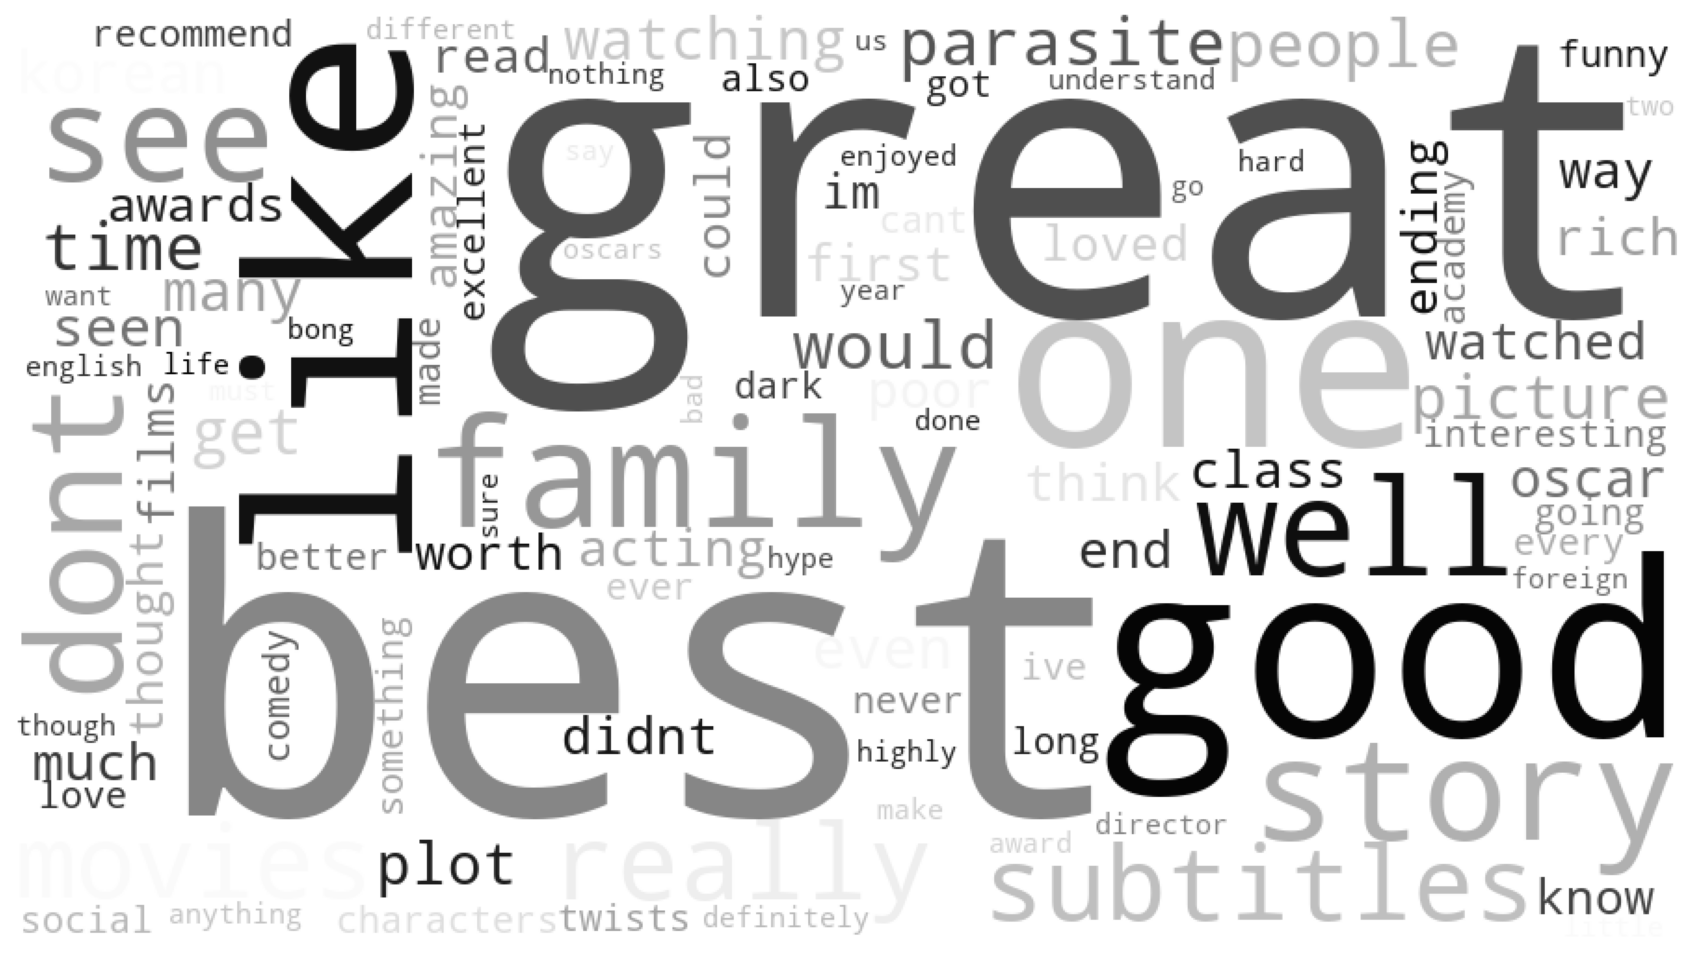

In [ ]:
wcdraw(movie_review_final, 'binary')

#기생충에 대한 해외 사람들의 평가가 긍정적임을 알 수 있다.